In [ ]:
!git clone https://github.com/SrinidhiBharadwaj/Scratch.git

Cloning into 'Scratch'...
remote: Enumerating objects: 5768, done.
remote: Counting objects: 100% (2140/2140), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 5768 (delta 1877), reused 2134 (delta 1871), pack-reused 3628
Receiving objects: 100% (5768/5768), 187.09 MiB | 48.30 MiB/s, done.
Resolving deltas: 100% (3511/3511), done.


In [40]:
from unetModel import simple_unet_model 
import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob

In [41]:
#Create image patches
import tifffile as tiff
from patchify import patchify
path = '/content/Scratch/Example-2/testImages/'
outPath = '/content/Scratch/SmallerPatches/images/'
#images = os.listdir(image_directory)
count = 0
for images in os.listdir(path):
    large_image_stack = tiff.imread(path + 'testImage' + str(count) +'.tif')
    for img in range(large_image_stack.shape[0]):
        large_image = large_image_stack[img]
        #patches_img = patchify(large_image, (128, 128), step=128)
        patches_img = patchify(large_image, (64, 64), step=64)  #Step=256 for 256 patches means no overlap 
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]): 
                single_patch_img = patches_img[i,j,:,:]
                tiff.imwrite(outPath  + 'testImage' + str(count) + '_image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)
    count+=1

In [42]:
path = '/content/Scratch/Example-2/testMasks/'
outPath = '/content/Scratch/SmallerPatches/masks/'
#images = os.listdir(image_directory)
count = 0
for images in os.listdir(path):
    large_image_stack = tiff.imread(path + 'testImage' + str(count) +'.tif')
    for img in range(large_image_stack.shape[0]):
        large_image = large_image_stack[img]
        patches_img = patchify(large_image, (64, 64), step=64)  #Step=256 for 256 patches means no overlap 
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]): 
                single_patch_img = patches_img[i,j,:,:]
                tiff.imwrite(outPath  + 'testImage' + str(count) + '_image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)
    count+=1

In [43]:
image_directory = '/content/Scratch/SmallerPatches/images/'
mask_directory = '/content/Scratch/SmallerPatches/masks/'

In [44]:
SIZE = 64
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
#Load the images from the dataset and save as numpy arrays
images = os.listdir(image_directory)
count=0
#Load the images from the dataset and save as numpy arrays
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_name)
        image = cv2.imread(image_directory+image_name, 0)
        mask = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))

In [45]:
#Normalize images and rescale masks between 0 and 1
import tensorflow as tf
image_dataset = np.expand_dims(tf.keras.utils.normalize(np.array(image_dataset), axis=1),3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
image_dataset.shape

(3072, 64, 64, 1)

In [46]:
#Split the dataset into training and testing to avoid over fitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

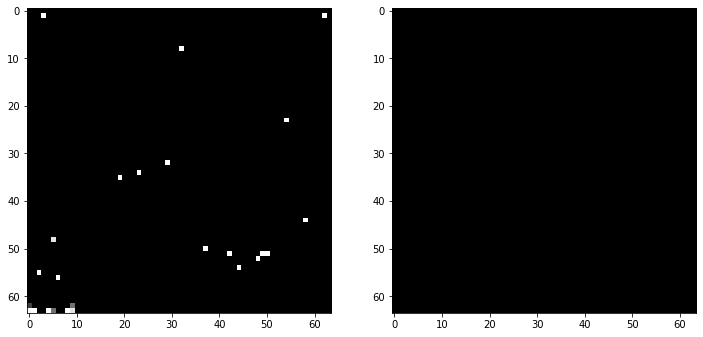

In [47]:
#Sanity check

import random
import numpy as np
image_number = random.randint(0, 3071)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (64,64)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (64,64)), cmap='gray')
plt.show()

In [48]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 64, 64, 16)   160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 64, 64, 16)   0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 64, 64, 16)   2320        dropout_27[0][0]                 
____________________________________________________________________________________________

In [49]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
173/173 [==============================] - 8s 25ms/step - loss: 0.1945 - accuracy: 0.9800 - val_loss: 0.0363 - val_accuracy: 0.9837
Epoch 2/10
173/173 [==============================] - 3s 17ms/step - loss: 0.0296 - accuracy: 0.9868 - val_loss: 0.0325 - val_accuracy: 0.9853
Epoch 3/10
173/173 [==============================] - 3s 17ms/step - loss: 0.0254 - accuracy: 0.9886 - val_loss: 0.0286 - val_accuracy: 0.9867
Epoch 4/10
173/173 [==============================] - 3s 17ms/step - loss: 0.0233 - accuracy: 0.9894 - val_loss: 0.0254 - val_accuracy: 0.9888
Epoch 5/10
173/173 [==============================] - 3s 17ms/step - loss: 0.0206 - accuracy: 0.9906 - val_loss: 0.0242 - val_accuracy: 0.9891
Epoch 6/10
173/173 [==============================] - 3s 17ms/step - loss: 0.0196 - accuracy: 0.9911 - val_loss: 0.0231 - val_accuracy: 0.9894
Epoch 7/10
173/173 [==============================] - 3s 16ms/step - loss: 0.0183 - accuracy: 0.9919 - val_loss: 0.0234 - val_accuracy: 0.9893

In [50]:
model.save('ModelBuiltOnUpdatedData64x64.hdf5')

In [51]:
model = get_model()
model.load_weights('/content/ModelBuiltOnUpdatedData64x64.hdf5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 64, 64, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 64, 64, 16)   0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 64, 64, 16)   2320        dropout_36[0][0]                 
____________________________________________________________________________________________

In [52]:
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

10/10 [==============================] - 3s 42ms/step - loss: 0.0159 - accuracy: 0.9930
Accuracy =  99.26892518997192 %


In [53]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7740291559475683


In [54]:
!pip install patchify

In [56]:
import tifffile as tiff
from tifffile import imread, imwrite
from patchify import patchify, unpatchify
from skimage.transform import resize
segmentedImages = []

data = imread('/content/JohTestImage.tif')
resized_data = resize(data, (57, 512, 512))
imwrite('/content/JohTestImageResized.tif', resized_data, planarconfig='CONTIG')

large_image_stack = tiff.imread('/content/JohTestImageResized.tif')

print(large_image_stack.shape)
count = 0
for img in range(large_image_stack.shape[0]):
    predicted_patches = []
    large_image = large_image_stack[img]
    patches_img = patchify(large_image, (SIZE, SIZE), step=SIZE)  #Step=256 for 256 patches means no overlap 
 
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]): 
            single_patch = patches_img[i,j,:,:]
            single_patch_norm = np.expand_dims(tf.keras.utils.normalize(np.array(single_patch), axis=1),2)
            single_patch_input=np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.1).astype(np.uint8)
           # single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]
            predicted_patches.append(single_patch_prediction)

    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches_img.shape[0], patches_img.shape[1], SIZE,SIZE) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
    segmentedImages.append(reconstructed_image)
    # im = Image.fromarray(reconstructed_image)
    # im.save('finalSegmentedImage'+str(count)+'.tif')
    #imsave('finalSegmentedImage'+str(count)+'.tif', reconstructed_image)
    # count+=1
    # plt.imshow(reconstructed_image, cmap='gray')
    # plt.savefig('/content/OutputMasks/finalSegmentedImage'+str(count)+'.tif')
    
    # plt.show()

hopefullyTheFinalImage = np.array(segmentedImages).astype(np.uint8)
# plt.figure(figsize=(16, 8))
# plt.imshow(hopefullyTheFinalImage, cmap='gray')
 

(57, 512, 512)


In [57]:
hopefullyTheFinalImage.shape

(57, 512, 512)

In [58]:
from tifffile import imsave
imsave('finalSegmentedImage64x64.tif', hopefullyTheFinalImage)


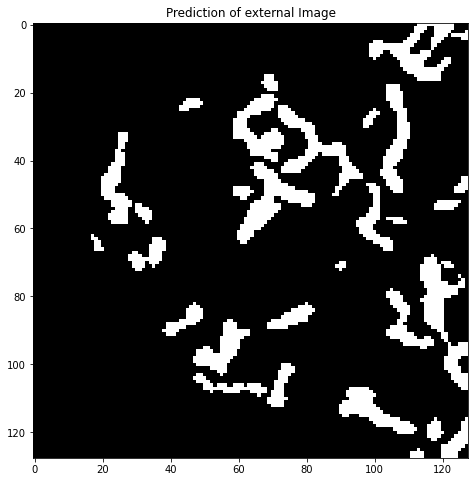

In [ ]:
test_img_other = cv2.imread('/content/testImage0_image_0_21.tif', 0)
test_img_other = cv2.resize(test_img_other, (SIZE, SIZE))
test_img_other_norm = np.expand_dims(tf.keras.utils.normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.1).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

In [ ]:
!zip -r /content/IndividualMasks.zip /content/OutputMasks

  adding: content/OutputMasks/ (stored 0%)
  adding: content/OutputMasks/finalSegmentedImage19.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage10.tif (deflated 97%)
  adding: content/OutputMasks/finalSegmentedImage54.tif (deflated 98%)
  adding: content/OutputMasks/finalSegmentedImage52.tif (deflated 98%)
  adding: content/OutputMasks/finalSegmentedImage56.tif (deflated 99%)
  adding: content/OutputMasks/finalSegmentedImage25.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage17.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage50.tif (deflated 97%)
  adding: content/OutputMasks/finalSegmentedImage26.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage20.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage1.tif (deflated 99%)
  adding: content/OutputMasks/finalSegmentedImage45.tif (deflated 96%)
  adding: content/OutputMasks/finalSegmentedImage49.tif (deflated 97%)
  adding: content/OutputMasks/.ipyn